# <font size= 1> <font color='FFFFFF'> **Regresión lineal y regresión logística**

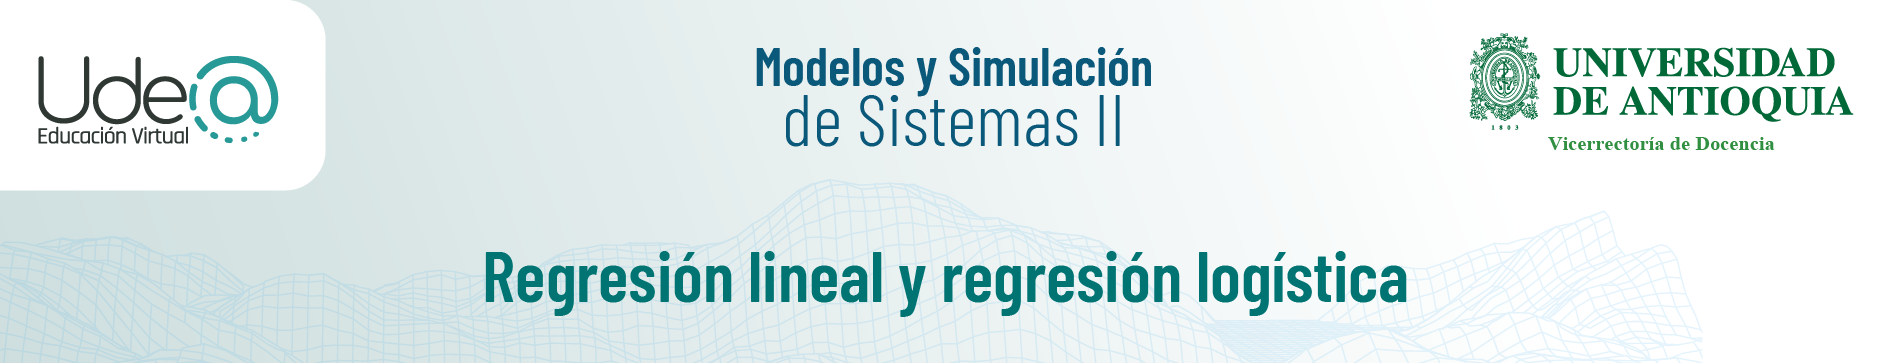



## <font size= 1> <font color='FFFFFF'> **Librerías y funciones** 

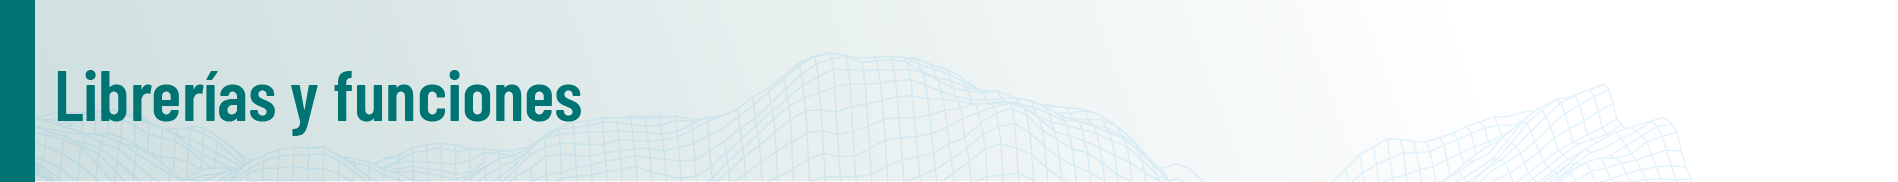

In [ ]:
# Librerias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
#from IPython.display import Image
#from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

### <font color='007473'>**Niveles de abstracción**

*   **Alto nivel:** uso de librerías que tienen definido un criterio y un algoritmo de entrenamiento implementado. 
*   **Nivel intermedio:** requiere modificar la función de costo para el entrenamiento. Uso de una librería de cálculo simbólico para la optimización de la nueva función.
*  **Bajo nivel:** selección del modelo y decisión sobre el cambio de la función criterio y/o del algoritmo de optimización. También se pueden hacer cambios en la formulación del modelo.


## <font size= 1> <font color='FFFFFF'> **Regresión lineal y regresión logística**

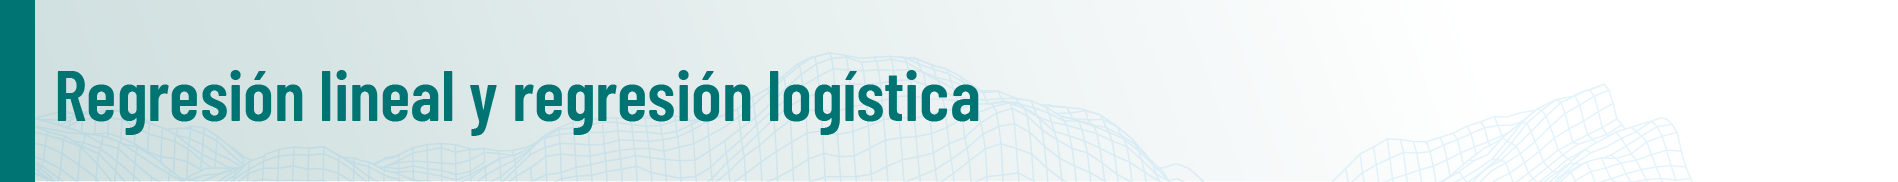

### <font color='007473'>**Ejemplo con datos generados artificialmente** 
A partir del conjunto de muestras obtenido con $y$, reconstruya el modelo dado.

$$
y = 3*x_1 + 7*x_2 - 2
$$

In [ ]:
fig = plt.figure(figsize=(14,6))
x1 = np.linspace(-10,10,100).reshape(100, 1)
x2 = x1**2

#Polinomio real
y = 3*x1 + 7*x2 - 2
X1, X2 = np.meshgrid(x1, x2)
Y = 3*X1 + 7*X2 - 2

# Nivel de error
Perror = 0.1

#Generar ruido en la medición
y2 = y + Perror*np.std(y)*(np.random.rand(100,1) - 0.5)
Y2 = y + Perror*np.std(y)*(np.random.rand(100,100) - 0.5)

#plots
## surface_plot with color grading and color bar
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X1, X2, Y, rstride=2, cstride=2, cmap=cm.jet, alpha=0.7)

# muestras con ruido
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X1, X2, Y2, rstride=2, cstride=2, cmap=cm.jet, alpha=0.7)
cb = fig.colorbar(p, shrink=0.5)



### **<font color='007473'> Estrategia de alto nivel (caja negra) </font>**
La librería Sklearn, dentro de las plantillas de modelos lineales, tiene una para regresión lineal: 

* [reg] Es el objeto de regresión lineal.
* Se tiene conocimiento de la entrada y la salida del modelo.
* [fit] Se hace el entrenamiento del modelo.



**¿Cómo construímos el modelo?**

In [ ]:
reg = LinearRegression().fit(np.c_[x1,x2], y2)

**¿Cómo hacemos una predicción?**

In [ ]:
reg.predict(np.array([8,5]).reshape(1,-1))

**¿Cuáles son los parámetros del modelo?**
Recordemos que el polinomio real es $y$ = $3*x_1$ + $7*x_2$ - $2$

In [ ]:
print(reg.coef_)
print(reg.intercept_)

**¿Cuál es el error de la predicción?**


In [ ]:
def ECM(w,x,y):
    w = w.reshape(1,-1)
    x = np.c_[x,np.ones((x1.shape[0],1))]
    return np.mean((np.dot(w,x.T).T-y)**2)

ECM(np.c_[reg.coef_,reg.intercept_], np.c_[x1,x2], y2)

### **<font color='007473'> Estrategia de nivel intermedio </font>**

* Sabemos que el problema que debemos resolver corresponde a un problema de minimización sin restricciones.

* Usaremos una librería llamada Scipy que tiene una función para realizar el proceso de optimización.

* Se optimizarán los pesos de $w$ a partir de la función ECM.

* Si ECM no nos satisface, podemos cambiar la función.


**¿Cuáles son los parámetros del modelo?**

In [ ]:
r1 = minimize(lambda w: ECM(w, np.c_[x1,x2], y2), np.random.random(size=3))
r1.x

**¿Cuál es el error de la predicción?**

In [ ]:
ECM(r1.x, np.c_[x1,x2], y2)

38.52806519400252

**¿Cómo hacemos una predicción?**

In [ ]:
np.dot(r1.x,np.array([8,5,1]))

### **<font color='007473'>  Estrategia de más bajo nivel </font>**
**Algoritmo de optimización: gradiente descendetente** 

Encontrar los parámetros es un proceso ITERATIVO.

In [ ]:
#Inicialización
MaxIter = 1000000
w = np.ones(3).reshape(3, 1)
eta = 0.0001
N = len(x1)
Error =np.zeros(MaxIter)

#Matriz extendida
X = np.array([x1,x2,np.ones((100,1))]).reshape(3, 100);

#Iteraciones
for i in range(MaxIter):
    tem = np.dot(X.T,w)
    tem2 = tem-np.array(y2)
    Error[i] = np.sum(tem2**2)/(2*N)
    tem = np.dot(X,tem2)
    w = w - eta*tem/N
#Gráfica
print(w)
plt.ylim(0,1000)
plt.xlim(0,200)
plt.ion()
plt.plot(np.linspace(0,MaxIter,MaxIter),Error)
plt.xlabel('Iteraciones')
plt.ylabel('$Error$')
plt.show()

**¿Cuál es el error de la predicción?**

In [ ]:
ECM(w, np.c_[x1,x2], y2)

**¿Cómo hacemos una predicción?**

In [ ]:
np.dot(w.T,np.array([8,5,1]))

----------------------------------------------------------------------------------------------------------------------------------------------

## <font size= 1> <font color='FFFFFF'> **<font color='007473'> Problema de clasificación </font>**

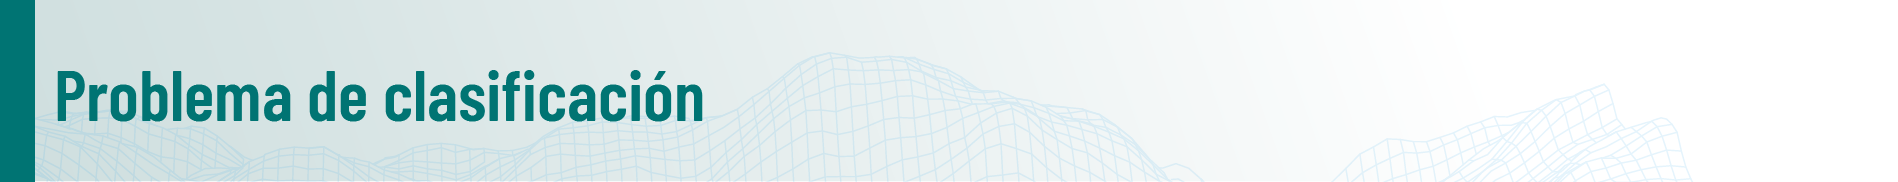

### <font color='007473'> **Regresión logística**

Usaremos el dataset Iris para el problema de clasificación. En el UCI Machine Learning Repository se halla más información: https://archive.ics.uci.edu/ml/datasets/iris

In [ ]:
# Función gradiente
def Gradiente(X2,y2,MaxIter = 100000):
    w = np.ones(3).reshape(3, 1)
    eta = 0.001
    N = len(y2)
    Error =np.zeros(MaxIter)
    Xent = np.concatenate((X2,np.ones((100,1))),axis=1)

    for i in range(MaxIter):
        tem = np.dot(Xent,w)
        tem2 = sigmoide(tem.T)-np.array(y2)
        Error[i] = np.sum(abs(tem2))/N
        tem = np.dot(Xent.T,tem2.T)
        wsig = w - eta*tem/N
        w = wsig
    return w, Error

def sigmoide(u):
        g = np.exp(u)/(1 + np.exp(u))
        return g

In [ ]:
iris = datasets.load_iris()
X, y = iris.data, iris.target
X2 = X[:100][:,:2]
y2 = y[:100]

w,Error = Gradiente(X2,y2)
iris = datasets.load_iris()
X, y = iris.data, iris.target
X2 = X[:100][:,:2]
y2 = y[:100]
plt.scatter(X2[:,0], X2[:,1], c=y2,s=40, alpha=.5, cmap="Accent",label='data set')
p = np.random.permutation(50)
p = p[0]
f = np.dot(np.r_[X2[p,:],1],w)
plt.scatter(X2[p,0], X2[p,1], s=40, alpha=.5, color="red", label='f='+str(f))
p = p+50
f = np.dot(np.r_[X2[p,:],1],w)
plt.scatter(X2[p,0], X2[p,1], s=40, alpha=.5, color="blue", label='f='+str(f))
x1 = np.linspace(4,8,20)
x2 = -(w[0]/w[1])*x1 - (w[2]/w[1])
plt.plot(x1,x2,'k',label='frontera')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

Si se pudiese encontrar la función dada por la línea negra en la figura anterior, la cual sería de la forma: 

$f({\bf{x}}) = w_1 x_1 + w_2 x_2 + w_0$.

Y teniendo en cuenta que los valores de las etiquetas para el problema de clasificación (las variables a predecir $t_i$) sólo pueden tomar dos valores ${0,1}$, entonces una forma simple de usar la función $f$ como clasificador sería asignar las muestras a la clase 1 cuando, al ser evaluadas en la función $f$, obtengan una valor positivo, y asignar 0 cuando suceda lo contrario.

$$\text{Class} = \left\{\begin{array}{ll}1\;\;\;{\rm{if}}\;\;\;w_0  + w_1 x_1  + w_2 x_2  +  \cdots  + w_d x_d  \geq 0\\0\;\;{\rm{\text{other wise}}}\end{array}\right. $$

**Efecto del número de iteraciones y de la tasa de aprendizaje**

In [ ]:
%matplotlib inline

def GradientSigmo(MaxIter=10000, eta = 0.001):
    plt.clf()
    plt.figure(figsize=(30,10))
    plt.axis([None, None, 0, 100])
    iris = datasets.load_iris()
    X, y = iris.data, iris.target
    X2 = X[:100][:,:2]
    y2 = y[:100]
    #Aprendizaje
    w = np.ones(3).reshape(3, 1)
    N = len(y2)
    Error =np.zeros(MaxIter)
    Xent = np.concatenate((X2,np.ones((100,1))),axis=1)

    for i in range(MaxIter):
        tem = np.dot(Xent,w)
        tem2 = sigmoide(tem.T)-np.array(y2)
        Error[i] = np.sum(np.abs(tem2))/N
        tem = np.dot(Xent.T,tem2.T)
        wsig = w - eta*tem/N
        w = wsig


    print(w)
    print('Error=',Error[-1])
    #Grafica de la frontera encontrada
    plt.subplot(1,2,2)
    iris = datasets.load_iris()
    X, y = iris.data, iris.target
    X2 = X[:100][:,:2]
    y2 = y[:100]
    plt.scatter(X2[:,0], X2[:,1], c=y2,cmap="Accent");
    x1 = np.linspace(4,8,20)
    x2 = -(w[0]/w[1])*x1 - (w[2]/w[1])
    
    plt.plot(x1,x2)
    plt.show()
    print(MaxIter,eta)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
interact(GradientSigmo,MaxIter=[1,10,100,1000,10000], eta=[0.0001,0.001,0.1,1,10]);  

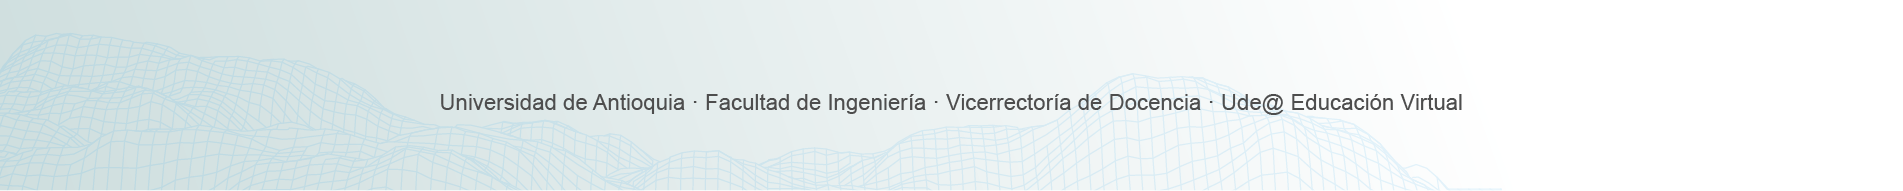